# PCA-based EEG Artifact Removal

In this assignment, we'll generate synthetic multi-channel EEG data that includes alpha waves, blink artifacts, and muscle noise. You'll apply PCA (via SVD) to isolate and remove a blink-related component. Then you'll compare signals before and after cleaning using PSD and spectrogram analysis.

**Objectives**:
1. Generate realistic EEG-like data with random alpha activity, global blinks, and localized muscle artifacts.
2. Perform PCA (through SVD).
3. Detect the blink component more intelligently than simply removing the top PC.
4. Reconstruct signals without that component and observe improvements.
5. Estimate alpha peak frequency and amplitude before and after cleaning.

We split this assignment into several parts, each with tasks for partial credit.
Let's begin!

## Part 1: Setup and Imports

**Task**: Import the necessary libraries (NumPy, Matplotlib, `scipy.signal`) and set up basic parameters.
We'll define sampling rate, duration, number of channels, and so forth. We'll also create a directory for saving any plots if needed.

In [313]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, spectrogram, find_peaks

np.random.seed(50)  
fs = 256
duration = 10 
n_samples = int(fs * duration)
t = np.linspace(0, duration, n_samples)
n_channels = 8


print(f'Setup done: fs={fs}, duration={duration}, n_channels={n_channels}, n_samples={n_samples}')

Setup done: fs=256, duration=10, n_channels=8, n_samples=2560


## Part 2: Generate Synthetic EEG Data

Here, you'll simulate alpha waves plus blink and muscle artifacts.
1. Each channel has a random alpha frequency (8-12 Hz), amplitude (10-30), and random phase.
2. We add random noise.
3. Insert global blink artifacts (e.g., short triangular pulses).
4. Insert localized muscle artifacts in some channels.

Recall that after performing SVD (`centered_data = U Σ V^T`), each *column* of `U` is a “spatial pattern” for a principal component (PC). Because our rows are EEG channels arranged from front to back on the scalp, a PC that has **large values** in the front channels (e.g., channels 1–2) and **smaller values** in the rear channels (e.g., channels 7–8) probably corresponds to a **blink** (frontal) artifact. Thus, to detect the blink component, we compare the **average loading** in the front channels vs. the back channels for each PC. If a PC shows a big difference there, and also has a large singular value, we suspect it’s the blink component.

**Tips**:
- Define a function or do it inline.
- Keep track of the final data shape = (n_channels, n_samples).
- You may want to store blink times for reference.

In [316]:
# STUDENT TODO:

# 2) For each channel, generate alpha wave + noise.
# 3) Insert blink artifacts at random times.
# 4) Insert muscle bursts in a few channels.

data = np.zeros((n_channels, n_samples))

alpha_f_min, alpha_f_max = 8.0, 12.0
noise_level = 3.0
num_blinks = 2

for ch in range(n_channels):
    f_alpha = np.random.uniform(alpha_f_min, alpha_f_max)
    alpha_amp = np.random.uniform(10.0, 30.0)
    alpha_phase = np.random.uniform(0, 2*np.pi)
    alpha_wave = alpha_amp * np.sin(2*np.pi*f_alpha * t + alpha_phase)
    noise = np.random.normal(0, noise_level, n_samples)
    data[ch] = alpha_wave + noise

# Insert blink artifacts

blink_times = np.sort(np.random.uniform(1.0, duration - 1.0, num_blinks))

channel_scaling = np.sort(np.random.uniform(0.0, 30.0, n_channels))[::-1]
blink_amp_base = 12.0

for bt in blink_times:
    center_idx = int(bt * fs)
    blink_width = np.random.uniform(0.0,1.0)
    half_w = int(blink_width * fs / 2)
    for i in range(center_idx - half_w, center_idx + half_w):
        if 0 <= i < n_samples:
            dist = abs(i - center_idx)
            shape_amp = 1.0 - dist / half_w
            if shape_amp < 0.0:
                shape_amp = 0.0
            for ch in range(n_channels):
                data[ch, i] += blink_amp_base * channel_scaling[ch] * shape_amp

# Insert muscle artifacts
num_muscle = int(np.random.uniform(0, 8))
chosen_channels = np.random.choice(n_channels, size=num_muscle, replace=False)
for ch in chosen_channels:
    burst_time = np.random.uniform(1.0, duration - 1.0)
    burst_start = int(burst_time * fs)
    burst_duration = np.random.uniform(0.0, 0.50)
    burst_len = int(burst_duration * fs)

    muscle_freq = np.random.uniform(20, 50)
    muscle_phase = np.random.uniform(0, 2*np.pi)
    muscle_amp_base = 5.0
    for i in range(burst_len):
        idx = burst_start + i
        if 0 <= idx < n_samples:
            data[ch, idx] += muscle_amp_base * np.sin(2*np.pi*muscle_freq * t[idx] + muscle_phase)

print(f'Generated data shape: {data.shape}')

Generated data shape: (8, 2560)


## Part 3: Inspect Raw Signals

Plot the raw signals in a single figure, offsetting each channel so we can see them distinctly.
**Task**:
- Make a time-domain plot of all channels.
- Label axes, title.

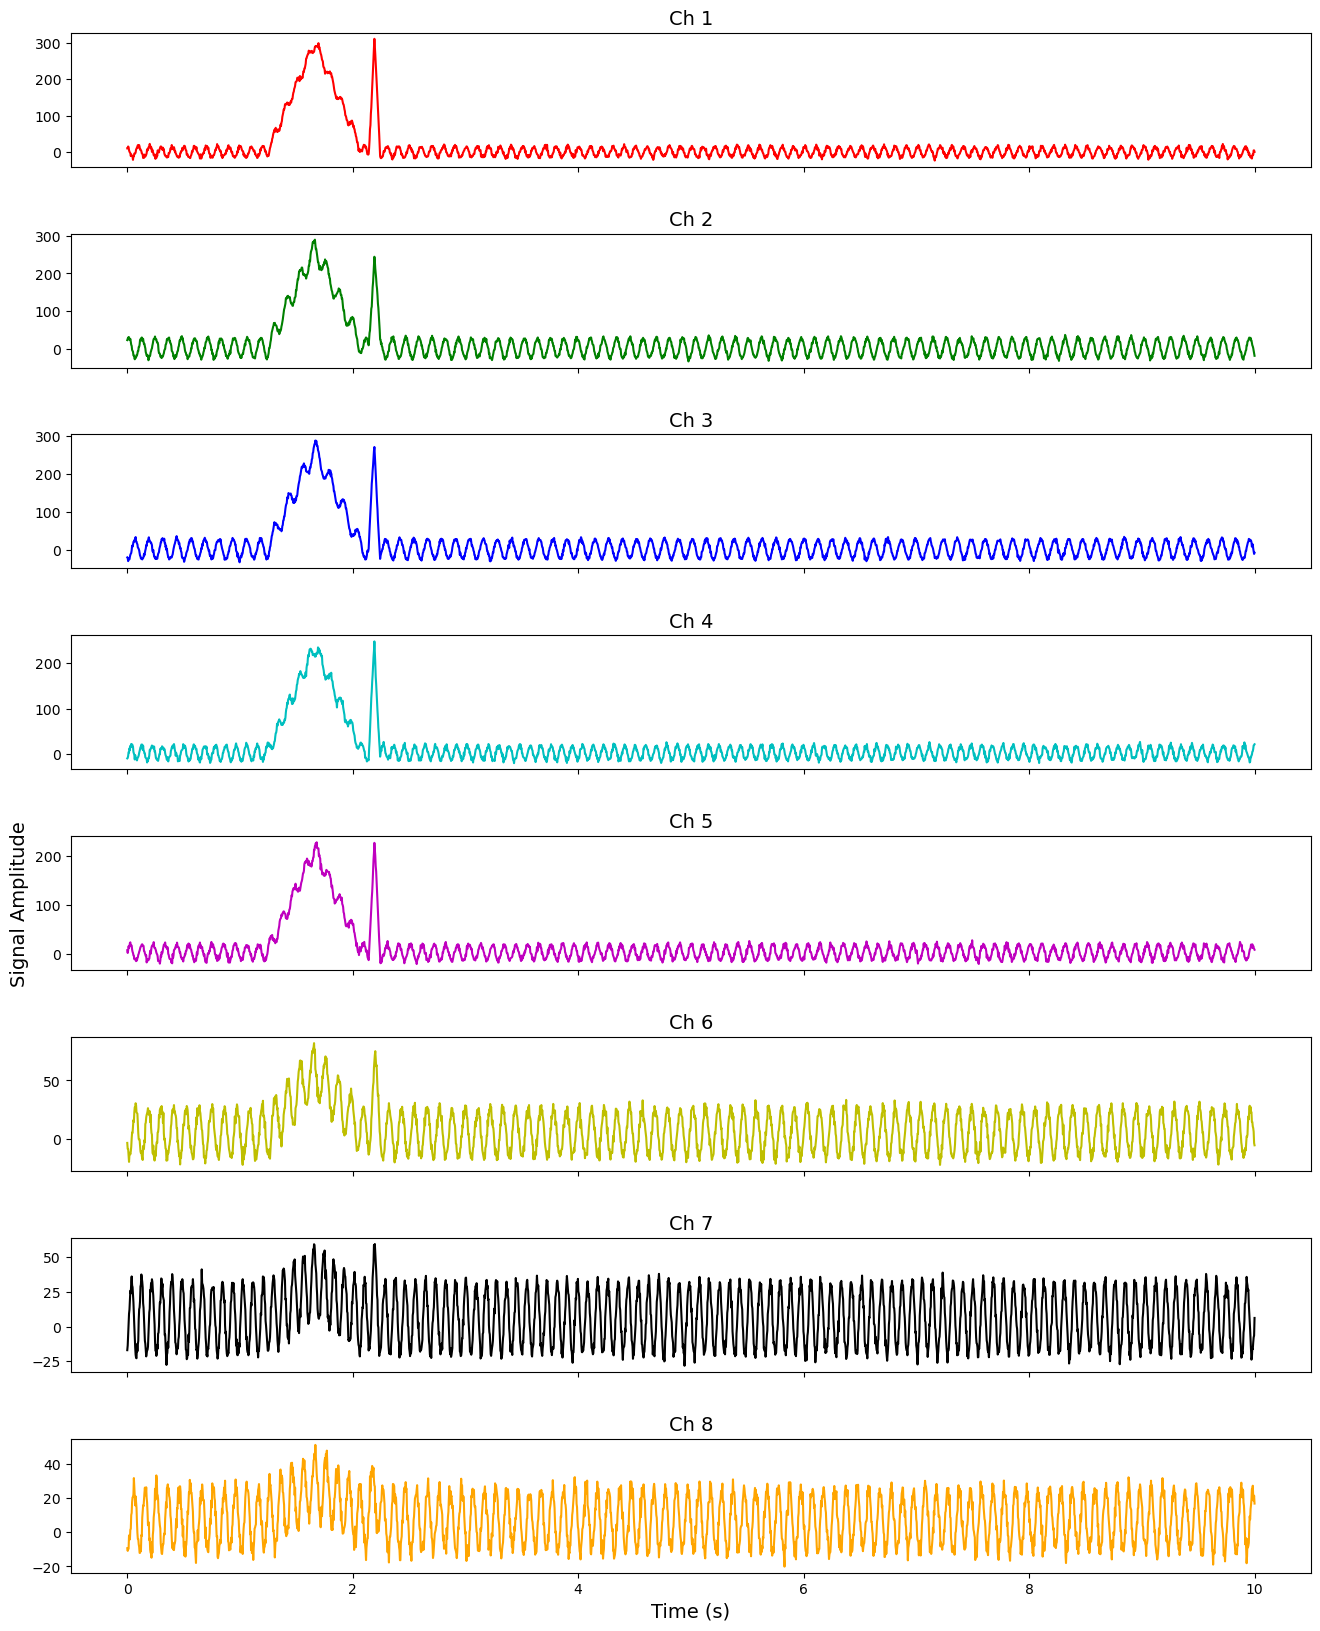

In [319]:
# STUDENT TODO:
# Plot the data. Add offsets to each trace to make it visible. Label the axis and ticks appropriately

fig, axes = plt.subplots(n_channels,1,figsize=(16, 20),sharex=True)
colors = [
    'r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown',
    'pink', 'lime', 'teal', 'gray', 'olive', 'navy'
]

for ch in range(n_channels):
    axes[ch].plot(t, data[ch] + ch,color=colors[ch], label=f'Ch {ch+1}')
    axes[ch].set_title(f'Ch {ch+1}',fontsize=14)


axes[-1].set_xlabel('Time (s)',fontsize=14)
axes[4].set_ylabel('Signal Amplitude',fontsize=14)
plt.subplots_adjust(hspace=0.5)
plt.show()

## Part 4: SVD-based PCA

We'll center the data, do an SVD, and interpret the singular values. Then we'll define a function to get principal components in the time domain.
**Tasks**:
1. Subtract each channel's mean.
2. Apply `np.linalg.svd`.
3. Plot singular values.
4. Write a function to produce PC time series = S diag * Vt.

Singular values: [5040.47525  955.98515  940.81119  834.84245  767.03382  736.54397  590.26652  449.09009]


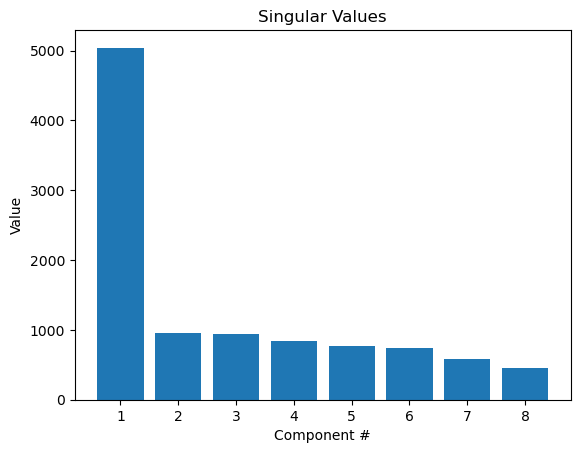

In [322]:
# STUDENT TODO:
for ch in range(n_channels):
    mean = np.mean(data[ch])
    centered_data= data[ch]-mean 
    data[ch] = centered_data
    
U, S, Vt = np.linalg.svd(data , full_matrices=True)



print('Singular values:', S)
# Plot them
plt.figure()
plt.bar(range(1, len(S)+1), S)
plt.title('Singular Values')
plt.xlabel('Component #')
plt.ylabel('Value')
plt.show()



In [324]:
def get_pc_time_series(U, S, Vt):
    smat = np.zeros((n_channels,n_samples))
    S = np.append(S, np.zeros((n_samples-n_channels)), axis=None)
    np.fill_diagonal(smat, S, wrap=False)
    pc_time_series = np.dot(smat,Vt)
    return pc_time_series

pc_time = get_pc_time_series(U, S, Vt)
print(f'PC time series shape: {pc_time.shape}')

PC time series shape: (8, 2560)


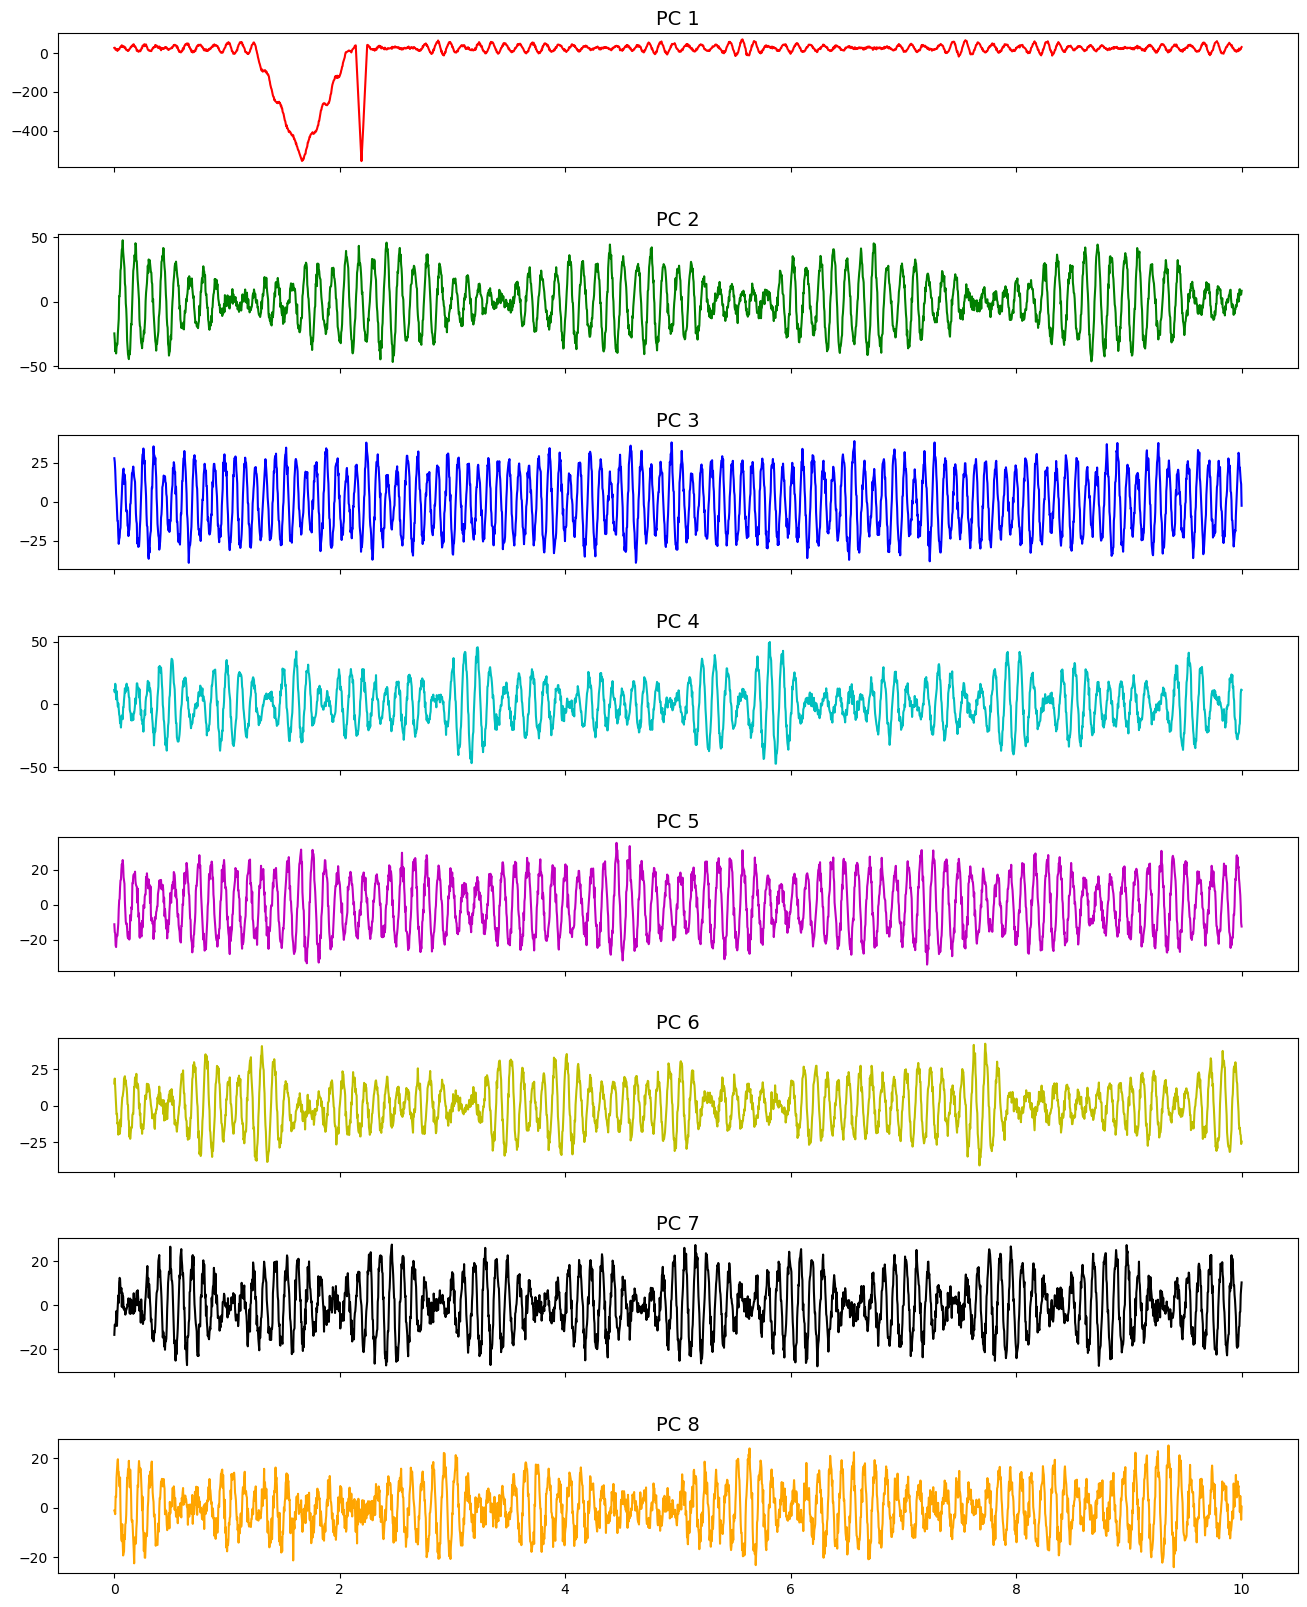

In [326]:
fig, axes = plt.subplots(n_channels,1,figsize=(16, 20),sharex=True)
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown',
          'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

for ch in range(n_channels):
    axes[ch].plot(t, pc_time[ch],color=colors[ch], label=f'Singular Value {ch+1}')
    axes[ch].set_title(f'PC {ch+1}',fontsize=14)


plt.subplots_adjust(hspace=0.5)
plt.show()

## Part 5: Detect & Remove Blink Component

**Tasks**:
1. Write a function to identify the blink PC by looking at the top 3 singular values and the ratio of front vs. back channels in U.
2. Set that singular value to 0, reconstruct the data.
3. Plot the cleaned signals in time.

[15.28905157674764, -5.112953689668109, -0.5863412151285049, -1.1259480473040784, -0.9352075748025669, -0.320232158622537, -0.12981426713426028, 1.1282986014453935]
Detected blink component: [0 1 7]


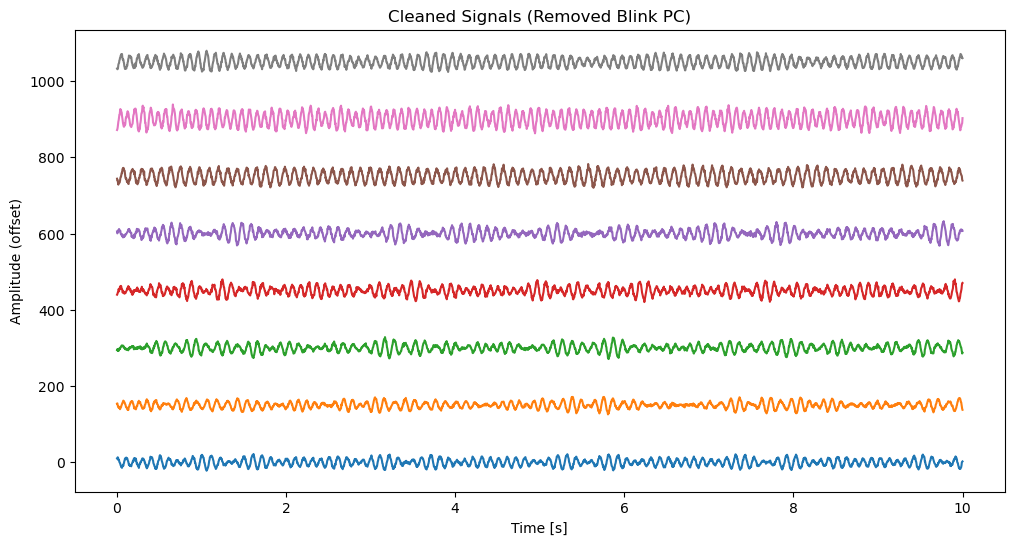

In [329]:
# STUDENT TODO:
# Example:
def detect_blink_component(U, S):
    singv_mat = np.dot(U,np.diag(S))
    u_ratio = []
    for n in range(8):
        u_ratio.append(U[0][n]/U[7][n])
    print(u_ratio)
    blink_idx = np.argsort(np.abs(u_ratio))[-3:][::-1]  
    return blink_idx

blink_comp_idx = detect_blink_component(U, S)
print(f'Detected blink component: {blink_comp_idx}')

def reconstruct_data(U, S, Vt, remove_list):
    S[remove_list] = 0.0
    Sigma_mod = np.zeros((U.shape[1], Vt.shape[0])) 
    np.fill_diagonal(Sigma_mod, S)
    return U @ Sigma_mod @ Vt

clean_centered = reconstruct_data(U, S, Vt, [blink_comp_idx])

for ch in range(n_channels):
    clean_centered[ch] += np.mean(data[ch])
    
#clean_data = clean_centered + np.array(mean_vals)

# Plot the cleaned signals with offsets
plt.figure(figsize=(12,6))

for ch in range(n_channels):
    plt.plot(t, clean_centered[ch] + ch*offset, label=f'Ch {ch+1}')
plt.title('Cleaned Signals (Removed Blink PC)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude (offset)')
plt.show()

## Part 6: PSD & Spectrogram + Alpha Wave Parameter

**Tasks**:
1. Compute & plot PSD (via `welch`) for raw vs. cleaned signals.
2. Compute & plot spectrogram on at least one channel.
3. Estimate alpha frequency/amplitude (peak in 8-12 Hz) before & after cleaning,
   and print the results.

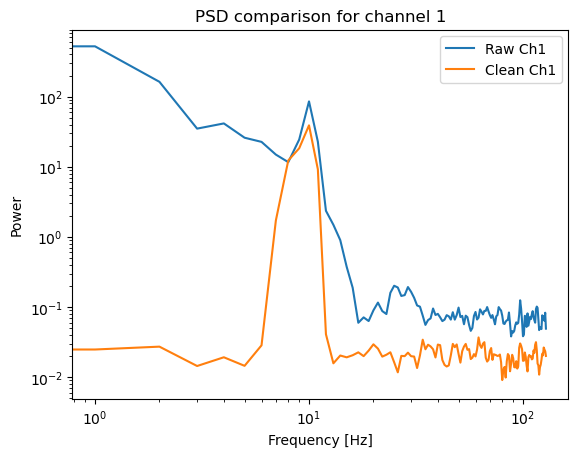

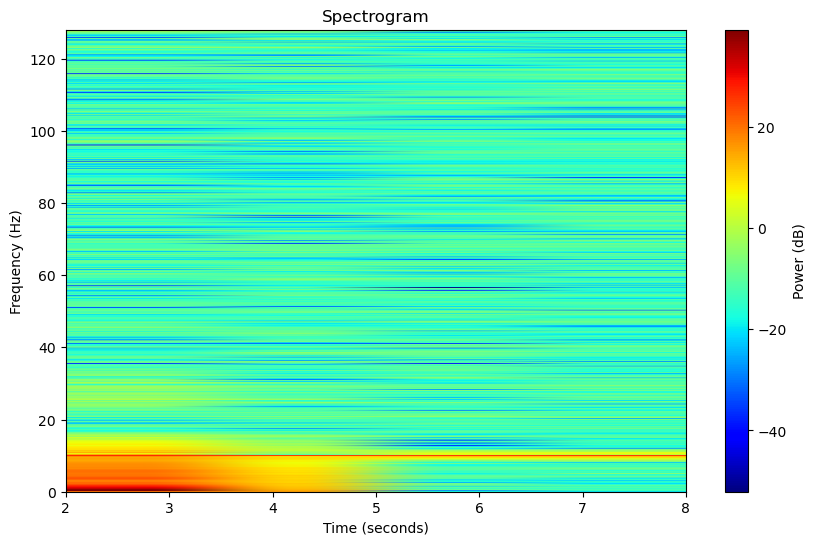

Raw Ch 1 has a peak frequency of 10.0 Hz, and a peak amplitude of 297.22723691389564

Clean Ch 1 has a peak frequency of 10.0 Hz, and a peak amplitude of 22.025119424333102

--------------------------------------------------------------------------------
Raw Ch 2 has a peak frequency of 9.0 Hz, and a peak amplitude of 276.36236013441567

Clean Ch 2 has a peak frequency of 8.0 Hz, and a peak amplitude of 21.668250013035042

--------------------------------------------------------------------------------
Raw Ch 3 has a peak frequency of 8.0 Hz, and a peak amplitude of 272.70583186121934

Clean Ch 3 has a peak frequency of 8.0 Hz, and a peak amplitude of 28.337882466956753

--------------------------------------------------------------------------------
Raw Ch 4 has a peak frequency of 11.0 Hz, and a peak amplitude of 233.6622447955343

Clean Ch 4 has a peak frequency of 11.0 Hz, and a peak amplitude of 29.778394268627373

------------------------------------------------------------------

In [332]:
# STUDENT TODO: partial code example
# PSD overlay
f_raw, p_raw = welch(data[0], fs=fs, nperseg=fs)
f_cln, p_cln = welch(clean_centered[0], fs=fs, nperseg=fs)

plt.figure()
plt.plot(f_raw, p_raw, label='Raw Ch1')
plt.plot(f_cln, p_cln, label='Clean Ch1')
plt.xscale('log'); plt.yscale('log')
plt.title('PSD comparison for channel 1')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend()
plt.show()

# Then do a spectrogram on channel 0, e.g.:
f_sp, t_sp, Sxx_raw = spectrogram(data[0], fs=fs, nperseg=1024, noverlap=512)
# Plot etc.
plt.figure(figsize=(10, 6))
plt.imshow(10 * np.log10(Sxx_raw), aspect='auto', cmap='jet', origin='lower', 
           extent=[t_sp[0], t_sp[-1], f_sp[0], f_sp[-1]])

plt.colorbar(label='Power (dB)')  
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (seconds)')
plt.title('Spectrogram')
plt.show()

# define a function to find alpha peak freq & amplitude.
# Then do it on each channel raw vs. cleaned, print results.

def peak_f_amp(channel):
    f, p = welch(channel, fs=fs, nperseg=fs)
    peak_freqs, _ = find_peaks(p, height=1.0,distance=4)
    peak_f = f[peak_freqs][-1]
    peak_amp = channel[np.argsort(channel)[-1]]
    return peak_f, peak_amp

for ch in range(n_channels):
    peak_f, peak_amp = peak_f_amp(data[ch])
    print(f'Raw Ch {ch+1} has a peak frequency of {peak_f} Hz, and a peak amplitude of {peak_amp}\n')
    peak_f, peak_amp = peak_f_amp(clean_centered[ch])
    print(f'Clean Ch {ch+1} has a peak frequency of {peak_f} Hz, and a peak amplitude of {peak_amp}\n')
    print('--------------------------------------------------------------------------------')
    